In [1]:
import os
import json
import pandas as pd

In [11]:
root_folder = "tunings"


# get all paths
all_paths = []
for dataset_folder in os.listdir(root_folder):
    if not os.path.isdir(os.path.join(root_folder, dataset_folder)):
        continue
    for tune_folder in os.listdir(os.path.join(root_folder, dataset_folder)):
        tune_path = os.path.join(root_folder, dataset_folder, tune_folder)
        all_paths.append(tune_path)
# get all configs, and best params
all_cfgs = []
all_best_params = []
for tune_path in all_paths:
    try:
        # load cfg and best params
        with open(os.path.join(tune_path, "cfg.json"), "r") as f:
            cfg = json.load(f)
        best_params = pd.read_csv(os.path.join(tune_path, "best_params.csv"), index_col=0)

        for param in best_params:
            if param in cfg:
                cfg[param] = best_params[param].values[0]
        # store
        all_cfgs.append(cfg)
        all_best_params.append(best_params)
    except FileNotFoundError:
        print(f"No cfg.json found in {tune_path}")




No cfg.json found in tunings/UKE_60/rnn_2022-03-11_15-00-13
No cfg.json found in tunings/UKE_60/rnn_2022-03-11_16-00-58
No cfg.json found in tunings/UKE_60/gpt_2022-03-23_22-12-02
No cfg.json found in tunings/UKE_60/xgb_2022-03-23_23-36-03
No cfg.json found in tunings/UKE_60/rnn_2022-03-19_23-09-26
No cfg.json found in tunings/UKE_60/gpt_2022-03-04_23-11-56
No cfg.json found in tunings/UKE_60/xgb_2022-03-23_23-39-33
No cfg.json found in tunings/UKE_60/gpt_2022-03-23_20-59-52
No cfg.json found in tunings/UKE_60/gpt_2022-03-22_20-26-34
No cfg.json found in tunings/UKE_60/xgb_2022-03-23_23-26-34
No cfg.json found in tunings/UKE_60/rnn_2022-03-23_23-31-22
No cfg.json found in tunings/UKE_60/rnn_2022-03-22_19-49-09
No cfg.json found in tunings/UKE_60/gpt_2022-03-19_21-05-46
No cfg.json found in tunings/UKE_60/gpt_2022-03-04_22-40-33
No cfg.json found in tunings/UKE_60/xgb_200_2022-04-15_09-08-11


In [37]:
# merge best param list of dfs in one big df
all_best_params_df = pd.concat(all_best_params).drop(columns=["fill_type"])
# merge cfg list to it
all_cfgs_df = pd.DataFrame(all_cfgs)
# merge cfg and best params df, avoiding reindexing error
all_df = pd.concat([all_cfgs_df.reset_index(drop=True), all_best_params_df.reset_index(drop=True)], axis=1)
# drop all coumns that contain only one unique value
all_df.drop(columns=all_df.nunique()[all_df.nunique()<=1].index, inplace=True)

In [38]:
all_df

,model_type,db_name,fill_type,bs,max_epochs,lr,weight_decay,grad_clip_val,hidden_size,mode,...,n_estimators,max_depth,subsample,colsample_bytree,gamma,min_child_weight,flat_block_size,C,max_iter,l1_ratio
0,gpt,MIMIC,none,6,30,0.001273,3.500000,0.500000,2048,adapters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xgb,MIMIC,median,8,30,0.015175,0.200000,1.000000,2048,adapters,...,120.0,3.0,0.80,1.00,2.300000,2.200000,5.0,NaN,NaN,NaN
2,linear,MIMIC,median,8,30,0.000100,0.200000,1.000000,2048,adapters,...,NaN,NaN,NaN,NaN,NaN,NaN,32.0,0.000057,164.0,0.0
3,rnn,MIMIC,median,2,30,0.000058,0.200000,0.400000,2048,adapters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,rnn,MIMIC,median,6,30,0.009297,3.200000,2.000000,512,adapters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,mlp,MIMIC,none,4,30,0.000912,1.300000,1.500000,2048,adapters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,mlp,MIMIC,none,6,30,0.000114,1.600000,1.200000,2048,adapters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,rnn,MIMIC,median,3,30,0.000055,0.600000,1.900000,4096,adapters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,rnn,MIMIC,median,4,30,0.005275,0.100000,0.000000,8,adapters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,mlp,MIMIC,median,6,30,0.000362,0.300000,0.200000,2048,adapters,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


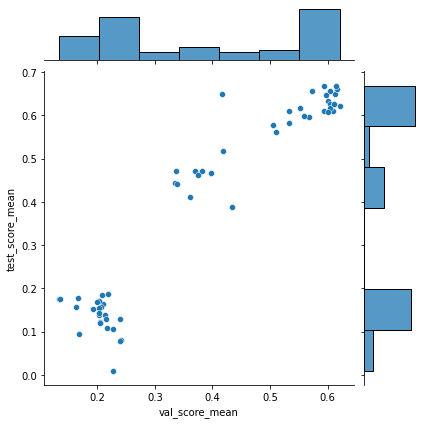

In [39]:
x = "val_score_mean"
y = "test_score_mean"

import seaborn as sns
#p = sns.regplot(x=x, y=y, data=all_df)

sns.jointplot(x=x, y=y, data=all_df)


In [40]:
all_df = all_df.drop(columns=["tree_method", "gpu"])

In [41]:
final_df = all_df[all_df["max_epochs"] == 30]
final_df = final_df[final_df["opt_steps"] == 200]

In [42]:
final_df.to_csv("tunings/final_df.csv")

In [43]:
final_df.columns

Index(['model_type', 'db_name', 'fill_type', 'bs', 'max_epochs', 'lr',
       'weight_decay', 'grad_clip_val', 'hidden_size', 'mode', 'pretrained',
       'flat_block_size', 'l1_ratio', 'n_estimators', 'max_depth',
       'min_child_weight', 'gamma', 'subsample', 'colsample_bytree',
       'opt_steps', 'norm_nan_embed', 'flat_block_size_range', 'lr',
       'weight_decay', 'grad_clip_val', 'bs', 'val_score_mean',
       'val_score_std', 'test_score_mean', 'test_score_std', 'n_estimators',
       'max_depth', 'subsample', 'colsample_bytree', 'gamma',
       'min_child_weight', 'flat_block_size', 'C', 'max_iter', 'l1_ratio'],
      dtype='object')

In [44]:
score_comp = final_df[["model_type", "db_name", "val_score_mean", "test_score_mean", "norm_nan_embed",
                      "pretrained", "hidden_size", "fill_type", "flat_block_size", "val_score_std", 
                      "test_score_std"]]

In [45]:
all_cfgs[0].keys()

dict_keys(['model_type', 'target_name', 'db_name', 'minutes', 'seed', 'features', 'fill_type', 'target_nan_quantile', 'block_size', 'random_starts', 'train_noise_std', 'bs', 'min_len', 'max_len', 'max_epochs', 'lr', 'use_nan_embed', 'weight_decay', 'grad_clip_val', 'val_check_interval', 'max_steps', 'use_macro_loss', 'use_pos_weight', 'use_huber', 'dropout', 'hidden_size', 'use_static', 'rnn_layers', 'rnn_type', 'mode', 'clip_name', 'gpt_name', 'pretrained', 'flat_block_size', 'alpha', 'l1_ratio', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'tree_method', 'gpu', 'opt_steps', 'tune_hebo'])

In [46]:
final_df.columns

Index(['model_type', 'db_name', 'fill_type', 'bs', 'max_epochs', 'lr',
       'weight_decay', 'grad_clip_val', 'hidden_size', 'mode', 'pretrained',
       'flat_block_size', 'l1_ratio', 'n_estimators', 'max_depth',
       'min_child_weight', 'gamma', 'subsample', 'colsample_bytree',
       'opt_steps', 'norm_nan_embed', 'flat_block_size_range', 'lr',
       'weight_decay', 'grad_clip_val', 'bs', 'val_score_mean',
       'val_score_std', 'test_score_mean', 'test_score_std', 'n_estimators',
       'max_depth', 'subsample', 'colsample_bytree', 'gamma',
       'min_child_weight', 'flat_block_size', 'C', 'max_iter', 'l1_ratio'],
      dtype='object')

,hidden_size,val_score_mean,val_score_std,test_score_mean,test_score_std
8,8,0.214511,0.016084,0.129973,0.034740
10,32,0.210027,0.008328,0.163328,0.011136
11,128,0.202388,0.010188,0.170638,0.004656
12,128,0.200199,0.007627,0.169311,0.004023
4,512,0.162698,0.027030,0.155981,0.013137
3,2048,0.219050,0.001164,0.187539,0.001484
7,4096,0.208223,0.004990,0.183832,0.002780


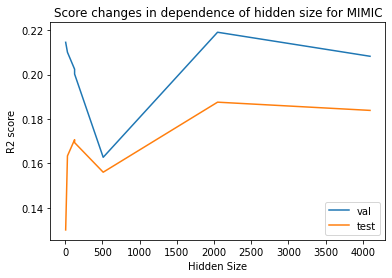

In [49]:
db = "MIMIC"
fill_type = "median"# "none", "median"

plot_df = score_comp[score_comp["db_name"] == db].sort_values("model_type").drop(columns=["db_name"])

first_models = plot_df[plot_df["fill_type"] == fill_type]

import matplotlib.pyplot as plt

# rnn best hidden size
rnn_df = first_models[first_models["model_type"] == "rnn"].sort_values("hidden_size").copy()
ax1 = rnn_df.plot(x="hidden_size", y="val_score_mean", kind="line", label="val")
rnn_df.plot(x="hidden_size", y="test_score_mean", kind="line", ax=ax1, label="test")
plt.ylabel("R2 score")
plt.xlabel("Hidden Size")
plt.title(f"Score changes in dependence of hidden size for {db}")
rnn_df[["hidden_size", "val_score_mean", "val_score_std", "test_score_mean", "test_score_std"]]


In [50]:
plot_df

,model_type,val_score_mean,test_score_mean,norm_nan_embed,pretrained,hidden_size,fill_type,flat_block_size,flat_block_size,val_score_std,test_score_std
0,gpt,0.214198,0.137506,NaN,1,2048,none,8.0,NaN,0.022471,0.021376
18,gpt,0.203035,0.142555,NaN,0,2048,median,8.0,NaN,0.003308,0.006054
17,gpt,0.202429,0.155031,NaN,0,2048,median,8.0,NaN,0.003513,0.004495
21,gpt,0.204325,0.120114,NaN,1,2048,median,8.0,NaN,0.031477,0.039351
2,linear,0.167050,0.177070,NaN,1,2048,median,32.0,32.0,0.000000,0.000000
19,mlp,0.240008,0.078218,0,1,2048,median,8.0,NaN,0.006915,0.004741
5,mlp,0.216556,0.108383,0,1,2048,none,8.0,NaN,0.005798,0.004763
6,mlp,0.238967,0.128347,1,1,2048,none,8.0,NaN,0.003585,0.004285
9,mlp,0.240922,0.079849,1,1,2048,median,8.0,NaN,0.006787,0.008114
15,rf,0.168498,0.093557,NaN,1,2048,median,32.0,32.0,0.000000,0.000000


,model_type,val_score_mean,test_score_mean,hidden_size,flat_block_size,flat_block_size,val_score_std,test_score_std
4,RNN,0.219050,0.187539,2048.0,8.0,NaN,0.001164,0.001484
1,LINEAR,0.167050,0.177070,2048.0,32.0,32.0,0.000000,0.000000
0,GPT,0.203263,0.139234,2048.0,8.0,NaN,0.012766,0.016633
3,RF,0.168498,0.093557,2048.0,32.0,32.0,0.000000,0.000000
2,MLP,0.240465,0.079033,2048.0,8.0,NaN,0.006851,0.006428
5,XGB,0.227294,0.009541,2048.0,5.0,5.0,0.012613,0.041947


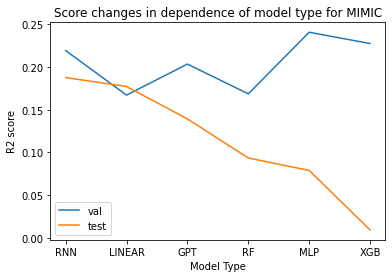

In [51]:
# plot for best model per model type
best_models = first_models[first_models["hidden_size"] == 2048].sort_values("model_type")
#best_models = best_models[(best_models["pretrained"] == 0) | (best_models["model_type"] != "gpt")]
best_models = best_models.groupby("model_type").mean().reset_index().sort_values("test_score_mean", ascending=False)
# capitalize model_type
best_models["model_type"] = best_models["model_type"].str.upper()
ax1 = best_models.plot(x="model_type", y="val_score_mean", kind="line", label="val")
ax2 = best_models.plot(x="model_type", y="test_score_mean", kind="line", label="test", ax=ax1)
plt.ylabel("R2 score")
plt.xlabel("Model Type")
plt.title(f"Score changes in dependence of model type for {db}")
#sns.barplot(x="model_type", y="val_score_mean", data=best_models)
# plot with std as error bar
#sns.barplot(x="model_type", y="val_score_mean", data=best_models, yerr="val_score_std")
best_models


In [52]:
fill_type_df = plot_df[plot_df["hidden_size"] == 2048].sort_values("model_type")

fill_type_df
#best_models = plot_df.groupby("model_type").mean().reset_index().sort_values("test_score_mean", ascending=False)



,model_type,val_score_mean,test_score_mean,norm_nan_embed,pretrained,hidden_size,fill_type,flat_block_size,flat_block_size,val_score_std,test_score_std
0,gpt,0.214198,0.137506,NaN,1,2048,none,8.0,NaN,0.022471,0.021376
18,gpt,0.203035,0.142555,NaN,0,2048,median,8.0,NaN,0.003308,0.006054
17,gpt,0.202429,0.155031,NaN,0,2048,median,8.0,NaN,0.003513,0.004495
21,gpt,0.204325,0.120114,NaN,1,2048,median,8.0,NaN,0.031477,0.039351
2,linear,0.167050,0.177070,NaN,1,2048,median,32.0,32.0,0.000000,0.000000
19,mlp,0.240008,0.078218,0,1,2048,median,8.0,NaN,0.006915,0.004741
5,mlp,0.216556,0.108383,0,1,2048,none,8.0,NaN,0.005798,0.004763
6,mlp,0.238967,0.128347,1,1,2048,none,8.0,NaN,0.003585,0.004285
9,mlp,0.240922,0.079849,1,1,2048,median,8.0,NaN,0.006787,0.008114
15,rf,0.168498,0.093557,NaN,1,2048,median,32.0,32.0,0.000000,0.000000


In [29]:
fill_type_df.groupby("model_type").apply(lambda model_df: model_df.groupby("fill_type").mean())

val_score_mean  test_score_mean  hidden_size  \
model_type fill_type                                                 
gpt        median           0.607269         0.614607       2048.0   
           none             0.572395         0.657517       2048.0   
linear     median           0.132717         0.174417       2048.0   
mlp        median           0.508371         0.569676       2048.0   
           none             0.475288         0.549638       2048.0   
rf         median           0.360712         0.411492       2048.0   
rnn        median           0.615531         0.660775       2048.0   
           none             0.612086         0.621384       2048.0   
xgb        median           0.363203         0.462016       2048.0   
           none             0.375124         0.462741       2048.0   

                      flat_block_size  flat_block_size  val_score_std  \
model_type fill_type                                                    
gpt        median                 8.0              NaN       0.056827   
           none                   8.0              NaN       0.037922   
linear     median                32.0             32.0       0.000000   
mlp        median                 8.0              NaN       0.004405   
           none                   8.0              NaN       0.003713   
rf         median                31.0             31.0       0.000000   
rnn        median                 8.0              NaN       0.018903   
           none                   8.0              NaN       0.024446   
xgb        median                17.0             17.0       0.018315   
           none                  32.0             32.0       0.020459   

                      test_score_std  
model_type fill_type                  
gpt        median       1.632341e-02  
           none         1.324722e-02  
linear     median       0.000000e+00  
mlp        median       4.838051e-03  
           none         4.003645e-03  
rf         median       5.551115e-17  
rnn        median       8.855067e-03  
           none         1.740286e-02  
xgb        median       1.172256e-02  
           none         1.249036e-02